In [217]:
import numpy as np
from qiskit import QuantumCircuit, transpile,assemble
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_state_hinton
from qiskit.visualization import plot_state_paulivec
from qiskit.visualization import plot_bloch_multivector
from qiskit import BasicAer
from qiskit import execute
from qiskit import Aer
from qiskit import IBMQ
from qiskit.circuit.library.standard_gates import CXGate
import math

%matplotlib inline

1/

On commence par créer des fonctions "utilitaires":

nbIt -> Donne le nombre d'itération de Grover en fonction du nb de bit du string (et du nombre de solution)

In [218]:
def nbIt(nbit,M):
    N = 2**nbit
    return round((((math.acos(math.sqrt(M/N)))/(2*math.asin(math.sqrt(M/N))))))

#Exemple pour 3 bit et 1 solution:
print("nb d'itération : ",nbIt(3,1))

nb d'itération :  2


Xgate -> Qui permet d'ajouter au circuit une porte X controllée sur le n-ième qubit controlée par les n-1 premier qubit.

In [129]:
def Xgate(circuit,n):
    l = []
    for i in range(n):
        l.append(i)
    cxg = CXGate().control(n-2)
    circuit.append(cxg, l)
    return circuit    

qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(6, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

c = Xgate(circuit,6)
c.draw()

q_0: ──■──
       │  
q_1: ──■──
       │  
q_2: ──■──
       │  
q_3: ──■──
       │  
q_4: ──■──
     ┌─┴─┐
q_5: ┤ X ├
     └───┘
c: 6/═════

Enfin on créé la fonction permettant de créer le circuit pour un string de n-bit.

In [219]:
def GroverXbit(s,n):
    s = s[::-1]
    
    #Creation d'un registre quantique et classique de n (taille du string de bit) qubit.
    qreg_q = QuantumRegister(n, 'q')
    creg_c = ClassicalRegister(n, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    
    #On applique l'opérateur d'Hadamard sur l'ensemble des qubits
    for i in range(n):
        circuit.h(qreg_q[i])

    #On calcule le nombre d'itération necessaire
    #On multiplie ce nombre par 2, car dans la suite du programme une itération est divisé en 2 cas: l'Oracle et l'opérateur de diffusion
    nbI = 2*nbIt(n,1)
    
    for i in range(nbI):
    #Implémentation de l'oracle
        if i%2 == 0:
            circuit.barrier()
            u = 0
    #On marque les qubits '0' dans l'état avec une porte X.
            for y in s:
                if y == '0':
                    circuit.x(qreg_q[u])
                u+=1
            circuit.barrier()
    #On applique l'opérateur d'Hadamard sur le dernier qubits
            circuit.h(qreg_q[n-1])
    #On applique l'opérateur X sur le dernier Qubit
            circuit = Xgate(circuit,n)
    #On applique l'opérateur d'Hadamard sur le dernier qubits
            circuit.h(qreg_q[n-1])
            
            circuit.barrier()
            u = 0
            for y in s:
                if y == '0':
                    circuit.x(qreg_q[u])
                u+=1
            circuit.barrier()
    #Implémentation d'opérateur de diffusion
        else:
            circuit.barrier()
    #On applique l'opérateur X sur l'ensemble des qubits
            for y in range(n):
                circuit.x(qreg_q[y])
            circuit.barrier()
            
    #On applique l'opérateur d'Hadamard sur le dernier qubits
            circuit.h(qreg_q[n-1])
    #On applique l'opérateur X sur le dernier Qubit
            circuit = Xgate(circuit,n)
    #On applique l'opérateur d'Hadamard sur le dernier qubits
            circuit.h(qreg_q[n-1])
            circuit.barrier()
    #On applique l'opérateur X sur l'ensemble des qubits
            for y in range(n):
                circuit.x(qreg_q[y])
            circuit.barrier()
    #On applique l'opérateur d'Hadamard sur l'ensemble des qubits
        for y in range(n):
            circuit.h(qreg_q[y])
    #On mesure l'ensemble des qubits
    circuit.measure_all()
    return circuit



On a le circuit suivant pour s="010":

In [220]:
c = GroverXbit("010",3)
c.draw()

┌───┐ ░ ┌───┐ ░                 ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░           »
   q_0: ┤ H ├─░─┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├─░─┤ X ├─░────────■──»
        ├───┤ ░ └───┘ ░        │        ░ └───┘ ░ ├───┤ ░ ├───┤ ░        │  »
   q_1: ┤ H ├─░───────░────────■────────░───────░─┤ H ├─░─┤ X ├─░────────■──»
        ├───┤ ░ ┌───┐ ░ ┌───┐┌─┴─┐┌───┐ ░ ┌───┐ ░ ├───┤ ░ ├───┤ ░ ┌───┐┌─┴─┐»
   q_2: ┤ H ├─░─┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ H ├─░─┤ X ├─░─┤ H ├┤ X ├»
        └───┘ ░ └───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘└───┘»
   c: 3/════════════════════════════════════════════════════════════════════»
                                                                            »
meas: 3/════════════════════════════════════════════════════════════════════»
                                                                            »
«              ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░                 ░ ┌───┐ ░ ┌───┐ ░ »
«   q_0: ──────░─┤ X ├─░─┤ H ├─░─┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├─░─»
«              ░ ├───┤ ░ ├───┤ ░ └───┘ ░        │        ░ └───┘ ░ ├───┤ ░ »
«   q_1: ──────░─┤ X ├─░─┤ H ├─░───────░────────■────────░───────░─┤ H ├─░─»
«        ┌───┐ ░ ├───┤ ░ ├───┤ ░ ┌───┐ ░ ┌───┐┌─┴─┐┌───┐ ░ ┌───┐ ░ ├───┤ ░ »
«   q_2: ┤ H ├─░─┤ X ├─░─┤ H ├─░─┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ H ├─░─»
«        └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘ ░ »
«   c: 3/══════════════════════════════════════════════════════════════════»
«                                                                          »
«meas: 3/══════════════════════════════════════════════════════════════════»
«                                                                          »
«        ┌───┐ ░                 ░ ┌───┐ ░ ┌───┐ ░ ┌─┐      
«   q_0: ┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├─░─┤M├──────
«        ├───┤ ░        │        ░ ├───┤ ░ ├───┤ ░ └╥┘┌─┐   
«   q_1: ┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├─░──╫─┤M├───
«        ├───┤ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤ ░ ├───┤ ░  ║ └╥┘┌─┐
«   q_2: ┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ H ├─░──╫──╫─┤M├
«        └───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘ ░  ║  ║ └╥┘
«   c: 3/═══════════════════════════════════════════╬══╬══╬═
«                                                   ║  ║  ║ 
«meas: 3/═══════════════════════════════════════════╩══╩══╩═
«                                                   0  1  2

On simule ce circuit et on obtient l'histogramme suivant:

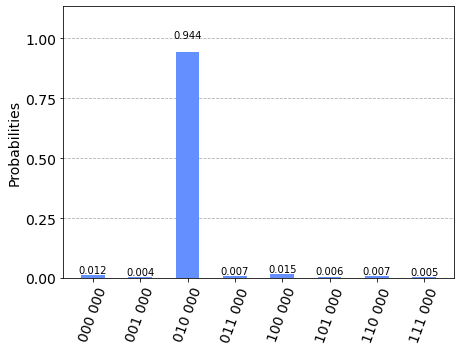

In [221]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(c, aer_sim)
qobj = assemble(transpiled_circuit,shots=1000)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer
plot_histogram(answer) 

Sur les machines d'IBM:

configrc.store_credentials:WARNING:2021-12-23 14:45:01,257: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-12-23 14:45:02,255: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


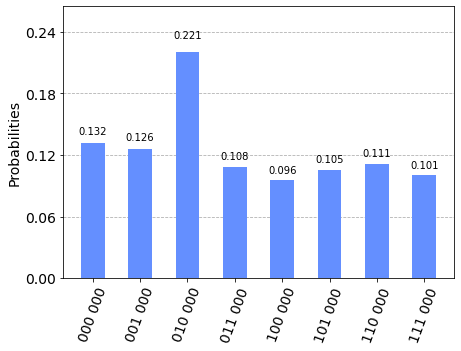

In [165]:
from qiskit.tools.monitor import job_monitor

IBMQ.save_account("4361710b3c0631d50aeb0306347dc3b4a91bbe8f1d6527cc7b762fa4750f386e3818018341ccfe5bfb0a0d226ae7a40fa0432cc7d10f87562860d8106f80454d")
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider('ibm-q')
provider.backends()
qcomp = provider.get_backend('ibmq_belem') #provider.backend(simulator = false, operational = true)

circuit = GroverXbit("010",3)
job = execute(circuit, backend=qcomp, shots=1024)
job_monitor(job)
result_hard = job.result()
plot_histogram(result_hard.get_counts(circuit))


In [222]:
c = GroverXbit("101",3)
c.draw()
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(c, aer_sim)
qobj = assemble(transpiled_circuit,shots=1000)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer
plot_histogram(answer) 

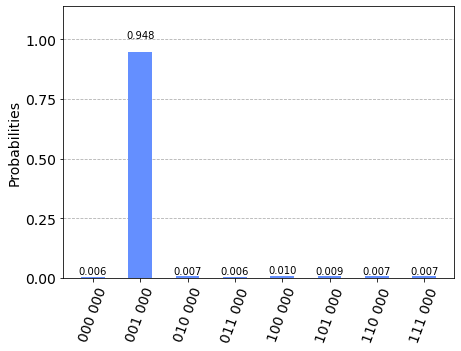

In [223]:
c = GroverXbit("001",3)
c.draw()
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(c, aer_sim)
qobj = assemble(transpiled_circuit,shots=1000)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer
plot_histogram(answer) 

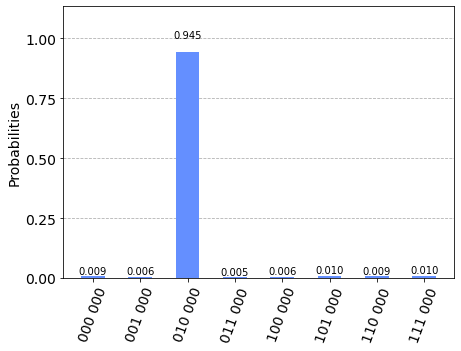

In [168]:
c = GroverXbit("010",3)
c.draw()
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(c, aer_sim)
qobj = assemble(transpiled_circuit,shots=1000)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer
plot_histogram(answer) 

2/
La fonction permettant de calculer le nb d'itéartion en fonction du nombre de bit et du nombre de solution. Pour une string de 5 bits on doit effectuer:

In [224]:
print(nbIt(5,1))

4


3/

GroverMultiXbit permet d'effectuer m fois le nb d'itération nécessaire:

In [225]:
def GroverMultiXbit(s,n,m):
    s = s[::-1]
    qreg_q = QuantumRegister(n, 'q')
    creg_c = ClassicalRegister(n, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    for i in range(n):
        circuit.h(qreg_q[i])
    
    #Il suffit de multiplier par n le nombre d'itération nécessaire
    nbI = 2*m
    
    for i in range(nbI):
        if i%2 == 0:
            circuit.barrier()
            u = 0
            for y in s:
                if y == '0':
                    circuit.x(qreg_q[u])
                u+=1
            circuit.barrier()
            
            circuit.h(qreg_q[n-1])
            circuit = Xgate(circuit,n)
            circuit.h(qreg_q[n-1])
            
            circuit.barrier()
            u = 0
            for y in s:
                if y == '0':
                    circuit.x(qreg_q[u])
                u+=1
            circuit.barrier()
        else:
            circuit.barrier()
            for y in range(n):
                circuit.x(qreg_q[y])
            circuit.barrier()
            circuit.h(qreg_q[n-1])
            circuit = Xgate(circuit,n)
            circuit.h(qreg_q[n-1])
            circuit.barrier()
            for y in range(n):
                circuit.x(qreg_q[y])
            circuit.barrier()
            
        for y in range(n):
            circuit.h(qreg_q[y])
    circuit.measure_all()
    return circuit


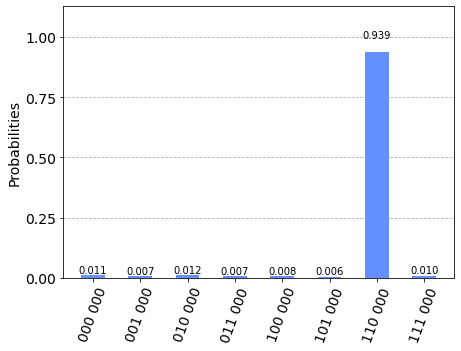

In [226]:
###Exéction 2*
c = GroverMultiXbit("110",3,2)
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(c, aer_sim)
qobj = assemble(transpiled_circuit,shots=1000)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer
plot_histogram(answer) 

#plot_histogram(answer) 

In [227]:
### Execution 3*
c = GroverMultiXbit("110",3,3)
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(c, aer_sim)
qobj = assemble(transpiled_circuit,shots=1000)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer
plot_histogram(answer) 

#plot_histogram(answer) 

Cela s'explique par le principe d'inversion de la moyenne -> si on dépasse le nombre d'itération optimal, on s'éloigne nécessairement du résulat.